# **Decision Tree Classification**
1. 의사결정 트리 분류기를 활용한다
1. 전체 n개의 feacture를 이분 분할시 **n개의** 경우의 수가 생성
1. 전체 n개의 feacture를 m 분할시 **$n^m$** 경우의 수가 가능하다

> Decision Tree 알고리즘

1. **ID3**(Iterative Dichotomiser 3)  Top Down 기법
1. **C4.5** : 생성한 Tree를 순회하는 백트래킹을 도입
1. **CART**(Classification and Regression Tree)
1. **CHAID**(Chi-square Automatic Interaction Detetor)

<img src="https://www.saedsayad.com/images/Decision_Tree_1.png" align="left" width=500>

## **1 CART 알고리즘의 구현**
1. **Decision Tree** 알고리즘 중 **CART** 를 구현한다
1. 범주형 데이터는 **오른쪽 자식 Node**에 우선 할당하고
1. 나머지는 **왼쪽 자식 Node**에 구분하여 할당한다

<br>
### **01 지니계수 : Tree 분할 비교기준**
1. 얼마나 잘 나뉘었는지 조합을 측정하기 위해서 **Gini Impurity** 와 **Information Gain**을 사용한다
1. **지니계수**(Gini Impurity)는 **해당 크래스의 순도/ 중첩비율을** 측정한다
1. 지니계수 **값이 작을수록**, 데이터 Set의 **순도비율이 높음을** 알 수 있다 (중첩이 적다/분류가 잘 된다)
1. Tree 모델을 비교시, **서브그룹의 지니계수를 더하기만** 하면 된다

$$ 지니계수 = 1 - \sum_{k=1}^{k} f_k^2 $$

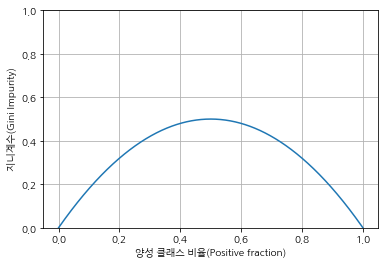

In [1]:
%matplotlib inline
from matplotlib import rc
rc('font', family=['NanumGothic','Malgun Gothic'])
import matplotlib.pyplot as plt
import numpy as np

# 0 ~ 1 사이의 값으로 2진분류에 따른 지니계수 변화
pos_fraction = np.linspace(0.00, 1.00, 1000)
gini         = 1 - pos_fraction ** 2 - (1-pos_fraction) ** 2
plt.plot(pos_fraction, gini)
plt.xlabel('양성 클래스 비율(Positive fraction)')
plt.ylabel('지니계수(Gini Impurity)')
plt.ylim(0, 1); plt.grid(); plt.show()

In [2]:
# 데이터set에 레이블이 있는경우 지니계수
def gini_impurity(labels):
    if not labels: # 레이블이 없는경우 0
        return 0
    counts = np.unique(labels, return_counts=True)[1]
    fractions = counts / float(len(labels))
    return 1 - np.sum(fractions ** 2)

print('{0:.4f}'.format(gini_impurity([])))
print('{0:.4f}'.format(gini_impurity([1, 1, 0, 1, 0])))
print('{0:.4f}'.format(gini_impurity([1, 1, 0, 1, 0, 0])))
print('{0:.4f}'.format(gini_impurity([1, 1, 1, 1])))

0.0000
0.4800
0.5000
0.0000


<br>
### **02 entropy 불확실성에 대한 확률 측정**
1. **엔트로피** : 불확실성에 대한 확률 측정값
1. 엔트로피 값이 **작을수록** 명확하고 순도가 높은 DataSet에 해당한다
1. 정보이득 = **분할 전** 엔트로피 - **분할 후** 엔트로피  = **부모** 엔트로피 - **자식** 엔트로피
1. 목표는 **정보이득이 최대가 되는 분할지점을** 찾는 것이다
1. 부모는 변하지 않으므로, **생성된 자식들의 엔트로피가 작을수록** 잘 구조화된 모델이 된다

/home/markbaum/Python/python/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log2
  
/home/markbaum/Python/python/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in multiply
  


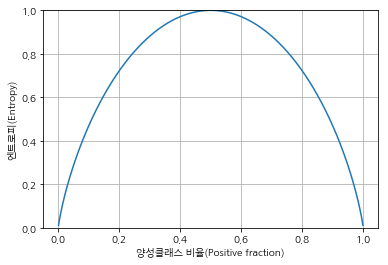

In [3]:
# import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)

# Plot entropy in binary case
pos_fraction = np.linspace(0.00, 1.00, 1000)
ent = - (pos_fraction * np.log2(pos_fraction) + (1 - pos_fraction) * np.log2(1 - pos_fraction))
plt.plot(pos_fraction, ent)
plt.xlabel('양성클래스 비율(Positive fraction)')
plt.ylabel('엔트로피(Entropy)')
plt.ylim(0, 1); plt.grid(); plt.show()

In [4]:
# DataSet 의 엔트로피 측정함수
def entropy(labels):
    if not labels:
        return 0
    counts = np.unique(labels, return_counts=True)[1]
    fractions = counts / float(len(labels))
    return - np.sum(fractions * np.log2(fractions))

for datum in [[1, 1, 0, 1, 0], [1, 1, 0, 1, 0, 0], [1, 1, 1, 1]]:
    print('{} 의 엔트로피 : {:.4f}'.format(datum, entropy(datum)))

[1, 1, 0, 1, 0] 의 엔트로피 : 0.9710
[1, 1, 0, 1, 0, 0] 의 엔트로피 : 1.0000
[1, 1, 1, 1] 의 엔트로피 : -0.0000


In [5]:
# 자식 Node들의 지니계수 측정
def information_gain(y, mask, func=entropy):
    s1 = np.sum(mask)
    s2 = mask.size - s1
    if (s1 == 0 | s2 == 0): return 0
    return func(y) - s1 / float(s1 + s2) * func(y[mask]) - s2 / float(s1 + s2) * func(y[np.logical_not(mask)])

In [6]:
# 지니계수와 엔트로피 특정
criterion_function = {'gini': gini_impurity, 
                      'entropy': entropy}

# Tree 분할 후 자식노드를 대상으로 가중치가 반영된 순도값 측정
def weighted_impurity(groups, criterion='gini'):
    total = sum(len(group) for group in groups)
    weighted_sum = 0.0
    for group in groups:
        weighted_sum += len(group) / float(total) * criterion_function[criterion](group)
    return weighted_sum

children_1 = [[1, 0, 1], [0, 1]]
children_2 = [[1, 1], [0, 0, 1]]
print('Entropy of #1 split: {0:.4f}'.format(weighted_impurity(children_1, 'entropy')))
print('Entropy of #2 split: {0:.4f}'.format(weighted_impurity(children_2, 'entropy')))

Entropy of #1 split: 0.9510
Entropy of #2 split: 0.5510


<br>
## **3 의사결정 Tree 함수를 구현**
최적의 Tree 모델을 구현하는데 필요한 함수들을 정의한다

In [7]:
def gini_impurity(labels):
    # When the set is empty, it is also pure
    if labels.size == 0:
        return 0
    # Count the occurrences of each label
    counts = np.unique(labels, return_counts=True)[1]
    fractions = counts / float(len(labels))
    return 1 - np.sum(fractions ** 2)

def entropy(labels):
    # When the set is empty, it is also pure
    if labels.size == 0:
        return 0
    counts = np.unique(labels, return_counts=True)[1]
    fractions = counts / float(len(labels))
    return - np.sum(fractions * np.log2(fractions))

criterion_function = {'gini': gini_impurity, 'entropy': entropy}
def weighted_impurity(groups, criterion='gini'):
    total = sum(len(group) for group in groups)
    weighted_sum = 0.0
    for group in groups:
        weighted_sum += len(group) / float(total) * criterion_function[criterion](group)
    return weighted_sum # float, weighted impurity

In [8]:
# feacture 와 Value를 사용하여 왼쪽/ 오른쪽 자식 Node로 분할하는 함수
def split_node(X, y, index, value):
    x_index = X[:, index]
    # 수치형 데이터인 경우
    if X[0, index].dtype.kind in ['i', 'f']:
        mask = x_index >= value
    # 범주형 데이터인 경우
    else:
        mask = x_index == value
    # 왼쪽 / 오른쪽 자식 Node로 분할한다
    left  = [X[~mask, :], y[~mask]]
    right = [X[mask, :], y[mask]]
    return left, right

In [9]:
# Tree 분할 후 최적의 모델을 출력한다
def get_best_split(X, y, criterion):
    # Obtain the best splitting point and resulting children for the data set X, y
    best_index, best_value, best_score, children = None, None, 1, None
    for index in range(len(X[0])):
        for value in np.sort(np.unique(X[:, index])):
            groups = split_node(X, y, index, value)
            impurity = weighted_impurity([groups[0][1], groups[1][1]], criterion)
            if impurity < best_score:
                best_index, best_value, best_score, children = index, value, impurity, groups
    # dict {index : index of the feature, value: feature value, children: left and right children}
    return {'index': best_index, 'value': best_value, 'children': children}

In [10]:
# 가장 많이 나타난 label로 leaf Node의 결과를 출력한다
def get_leaf(labels):
    return np.bincount(labels).argmax()

In [11]:
# Node를 생성하거나, Leaf Node에 할당하기 위해 현재의 Node를 자식Node로 분할
def split(node, max_depth, min_size, depth, criterion):
    """ Args >>>
        node : (dict, 자식 정보가 포함)
        max_depth : (int, 생성할 tree의 최대 깊이)
        min_size : (int, 자식 노드를 추가/불할시 필요한 최소의 샘플갯수)
        depth : (int, 노드의 현재깊이)
        criterion : (gini 또는 entropy) """
    left, right = node['children']
    del (node['children'])
    if left[1].size == 0:
        node['right'] = get_leaf(right[1])
        return
    if right[1].size == 0:
        node['left'] = get_leaf(left[1])
        return
    # 현재 생성한 깊이가 최대설정값을 초과하는지 여부를 판단
    if depth >= max_depth:
        node['left'], node['right'] = get_leaf(left[1]), get_leaf(right[1])
        return
    # 왼쪽 자식 노드에 샘플데이터가 많은지를 검사한다
    if left[1].size <= min_size:
        node['left'] = get_leaf(left[1])
    else:
        # 샘플데이터가 많으면 추가분할을 수행한다
        result = get_best_split(left[0], left[1], criterion)
        result_left, result_right = result['children']
        if result_left[1].size == 0:
            node['left'] = get_leaf(result_right[1])
        elif result_right[1].size == 0:
            node['left'] = get_leaf(result_left[1])
        else:
            node['left'] = result
            split(node['left'], max_depth, min_size, depth + 1, criterion)
    # 오른쪽 자식 노드에 샘플데이터가 많은지 검사한다
    if right[1].size <= min_size:
        node['right'] = get_leaf(right[1])
    else:
        # 샘플 데이터가 많으면, 추가 분할을 수행한다
        result = get_best_split(right[0], right[1], criterion)
        result_left, result_right = result['children']
        if result_left[1].size == 0:
            node['right'] = get_leaf(result_right[1])
        elif result_right[1].size == 0:
            node['right'] = get_leaf(result_left[1])
        else:
            node['right'] = result
            split(node['right'], max_depth, min_size, depth + 1, criterion)

In [12]:
# tree 생성을 위한 함수를 정의한다
def train_tree(X_train, y_train, max_depth, min_size, criterion='gini'):
    """ Args >>>
        X_train,  y_train (list, list, 학습 데이터)
        max_depth (int, tree의 최대 깊이)
        min_size  (int, 자식 노드를 추가 분할하는데 필요한 최소한의 샘플갯수)
        criterion (gini 또는 entropy) """
    X = np.array(X_train)
    y = np.array(y_train)
    root = get_best_split(X, y, criterion)
    split(root, max_depth, min_size, 1, criterion)
    return root

In [13]:
# 생성한 Tree 구조를 화면에 출력하는 파라미터와 함수
CONDITION = {'numerical'  : {'yes': '>=', 'no': '<'},
             'categorical': {'yes': 'is', 'no': 'is not'}}

def visualize_tree(node, depth=0):
    if isinstance(node, dict):
        if node['value'].dtype.kind in ['i', 'f']:
            condition = CONDITION['numerical']
        else:
            condition = CONDITION['categorical']
        print('{}|- X{} {} {}'.format(depth * '  ', node['index'] + 1, condition['no'], node['value']))
        if 'left' in node:
            visualize_tree(node['left'], depth + 1)
        print('{}|- X{} {} {}'.format(depth * '  ', node['index'] + 1, condition['yes'], node['value']))
        if 'right' in node:
            visualize_tree(node['right'], depth + 1)
    else:
        print('{}[{}]'.format(depth * '  ', node))

<br>
## **4 의사결정 Tree 예제 Data로 구현해보기**
수치형 예제 데이터로 test를 진행한다

In [14]:
X_train = [['tech', 'professional'],
           ['fashion', 'student'],
           ['fashion', 'professional'],
           ['sports', 'student'],
           ['tech', 'student'],
           ['tech', 'retired'],
           ['sports', 'professional']]

y_train = [1,0,0,0,1,0,1]
tree = train_tree(X_train, y_train, 2, 2)
visualize_tree(tree)

|- X1 is not fashion
  |- X2 is not professional
    [0]
  |- X2 is professional
    [1]
|- X1 is fashion
  [0]


In [15]:
X_train_n = [[6, 7],[2, 4],[7, 2],[3, 6],[4, 7],
             [5, 2],[1, 6],[2, 0],[6, 3],[4, 1]]

y_train_n = [0,0,0,0,0,1,1,1,1,1]

tree = train_tree(X_train_n, y_train_n, 2, 2)
visualize_tree(tree)

|- X2 < 4
  |- X1 < 7
    [1]
  |- X1 >= 7
    [0]
|- X2 >= 4
  |- X1 < 2
    [1]
  |- X1 >= 2
    [0]


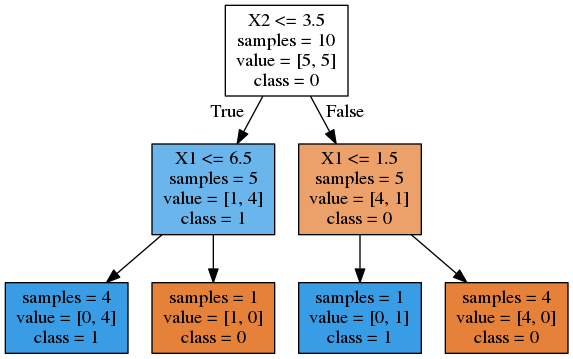

In [16]:
# graphviz 로 Tree 구조를 외부파일로 출력하기
from sklearn.tree import DecisionTreeClassifier
tree_sk = DecisionTreeClassifier(criterion='gini', max_depth=2, min_samples_split=2)
tree_sk.fit(X_train_n, y_train_n)

from sklearn.tree import export_graphviz
inter = export_graphviz(tree_sk, 
                out_file      = './data/tree.dot', 
                feature_names = ['X1', 'X2'], 
                impurity      = False, 
                filled        = True, 
                class_names   = ['0', '1'])

import os
from IPython.display import Image
os.system('dot -Tpng ./data/tree.dot -o ./data/tree.png') # .dot 파일을 .png 로 변환
Image(filename='./data/tree.png', width=500) 

<br>
# **Click Through Rate**
1. **CRT** (Click Through Rate) : **전체 페이지 뷰** 횟수 대비 **특정광고 클릭횟수** 비율
1. **CRT** 값이 클수록 **Target Marketing이** 잘 되었음을 의미한다
1. **Feacture**들은 **범주형**데이터로 구성되어 있고, 이를 **수치화를** 해도 **구분만 함에** 유의할 것
1. **광고 콘텐츠 및 정보**
1. **페이지 콘텐츠 및 광고 정보**
1. **광고 수신측 정보**

## **1 Decision Tree를 이용한 Click Through Rate 예측하기**
전체 데이터 중 100,000개만 추출하여 모델을 학습한다

> **데이터 살펴보기**

1. **Site_ID** : 광고 ID
1. **Click (y_train_data)** : 클릭 여부 (0, 1)
1. **C1, C14 ~ C19** : 익명처리된 카테고리 변수
1. **banner_pos** : 배너의 위치
1. **site_id** : 웹사이트 ID
1. **app_id** : 모바일앱 ID

<br>
### **01 데이터 불러오기**
**Click Trough Rate Prediction** [압축1GB](https://www.kaggle.com/c/avazu-ctr-prediction/data)

In [17]:
# 6GB 데이터를, 필요한 인덱스 까지 순차적 메모리 호출
# 대용량 데이터를 메모리로 호출하는 경우 활용하기에 적합
def read_ad_click_data(n, offset=0):
    import csv
    X_dict, y = [], []
    with open('./data/train.csv', 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        for i in range(offset):
            next(reader)
        i = 0
        for row in reader:
            i += 1
            y.append(int(row['click']))
            del row['click'], row['id'], row['hour'], row['device_id'], row['device_ip']
            X_dict.append(dict(row))
            if i >= n:
                break
    return X_dict, y

n = 10000  # 데이터를 줄여서 10,000개로 학습
X_dict_train, y_train = read_ad_click_data(n)
print(X_dict_train[0])
print(X_dict_train[1])

{'C1': '1005', 'C14': '15706', 'C15': '320', 'C16': '50', 'C17': '1722', 'C18': '0', 'C19': '35', 'C20': '-1', 'C21': '79', 'app_category': '07d7df22', 'app_domain': '7801e8d9', 'app_id': 'ecad2386', 'banner_pos': '0', 'device_conn_type': '2', 'device_model': '44956a24', 'device_type': '1', 'site_category': '28905ebd', 'site_domain': 'f3845767', 'site_id': '1fbe01fe'}
{'C1': '1005', 'C14': '15704', 'C15': '320', 'C16': '50', 'C17': '1722', 'C18': '0', 'C19': '35', 'C20': '100084', 'C21': '79', 'app_category': '07d7df22', 'app_domain': '7801e8d9', 'app_id': 'ecad2386', 'banner_pos': '0', 'device_conn_type': '0', 'device_model': '711ee120', 'device_type': '1', 'site_category': '28905ebd', 'site_domain': 'f3845767', 'site_id': '1fbe01fe'}


In [18]:
# sklearn 의 Tree 기반의 알고리즘에 적합한 형태로 변환
# 19개 컬럼 데이터를, 5725 차원의 이진 데이터(One-Hot)로 변형 (약 500Mb 늘어남)
# Train 데이터 생성하기
from sklearn.feature_extraction import DictVectorizer
dict_one_hot_encoder = DictVectorizer(sparse = False)
X_train              = dict_one_hot_encoder.fit_transform(X_dict_train)

# Test 데이터 생성하기
X_dict_test, y_test = read_ad_click_data(n, n)
X_test = dict_one_hot_encoder.transform(X_dict_test)
print("X_train DataSet (0~10,000) : {:,}\nX_test DataSet (10,000~20,000) : {:,}".format(
    len(X_train[0]),len(X_test[0])))

X_train DataSet (0~10,000) : 2,820
X_test DataSet (10,000~20,000) : 2,820


<br>
### **02 Decision Tree Classifier 모델 학습**
1. **DecisionTreeClassifier** 모듈을 사용하여 최적의 파라미터를 예측한다
1. max_depth **최대 깊이 설정값만** 입력하면 조건내 **최적의 파라미터를** 출력한다

In [19]:
from sklearn.tree import DecisionTreeClassifier
parameters = {'max_depth': [3, 10, None]}
decision_tree = DecisionTreeClassifier(criterion='gini', min_samples_split=30)

from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(decision_tree, parameters, n_jobs=-1, cv=3, scoring='roc_auc')

grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

{'max_depth': 10}


In [20]:
# 100,000개로 학습히 0.692 정확도를 출력한다
# 데이터 크기가 그렇게 크게 좌우되진 않는 듯
decision_tree_best = grid_search.best_estimator_
pos_prob = decision_tree_best.predict_proba(X_test)[:, 1]

from sklearn.metrics import roc_auc_score
print('The ROC AUC on testing set is: {0:.3f}'.format(roc_auc_score(y_test, pos_prob)))

The ROC AUC on testing set is: 0.671


<br>
### **03 Random Foreset classifier 모델 학습**
1. **RandomForestClassifier** 모듈을 사용하여 최적의 파라미터를 예측한다
1. **max_dapth** 파라미터만 변경하면 된다

In [21]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators=100, criterion='gini', min_samples_split=30, n_jobs=-1)
grid_search   = GridSearchCV(random_forest, parameters, n_jobs=-1, cv=3, scoring='roc_auc')
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)

/home/markbaum/Python/python/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


{'max_depth': None}
0.6956435223102432


In [22]:
# 위의 Decision tree 보다 Random Foreset Classifier 성능이 더 좋다
random_forest_best = grid_search.best_estimator_
pos_prob = random_forest_best.predict_proba(X_test)[:, 1]
print('The ROC AUC on testing set is: {0:.3f}'.format(roc_auc_score(y_test, pos_prob)))

The ROC AUC on testing set is: 0.713
